In [ ]:
import cv2
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
import matplotlib.pyplot as plt

In [ ]:
train_dir = '/content/drive/MyDrive/dataset/train'
val_dir = '/content/drive/MyDrive/dataset/test'
emotion_labels = ['ANGRY', 'HAPPY', 'SAD', 'NEUTRAL']


In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    batch_size=32,
    color_mode='grayscale',
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(48, 48),
    batch_size=32,
    color_mode='grayscale',
    class_mode='categorical'
)

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator
)

model.save('detection_model.h5')
print("Model saved as detection_model.h5")

Found 4531 images belonging to 4 classes.
Found 2164 images belonging to 4 classes.
Epoch 1/30
142/142 [==============================] - 30s 208ms/step - loss: 1.3649 - accuracy: 0.2984 - val_loss: 1.3984 - val_accuracy: 0.2800
Epoch 2/30
142/142 [==============================] - 30s 208ms/step - loss: 1.3262 - accuracy: 0.3540 - val_loss: 1.3498 - val_accuracy: 0.3198
Epoch 3/30
142/142 [==============================] - 32s 228ms/step - loss: 1.2810 - accuracy: 0.4001 - val_loss: 1.2941 - val_accuracy: 0.3933
Epoch 4/30
142/142 [==============================] - 30s 211ms/step - loss: 1.2274 - accuracy: 0.4436 - val_loss: 1.2591 - val_accuracy: 0.4450
Epoch 5/30
142/142 [==============================] - 31s 215ms/step - loss: 1.1577 - accuracy: 0.4825 - val_loss: 1.1876 - val_accuracy: 0.4616
Epoch 6/30
142/142 [==============================] - 33s 233ms/step - loss: 1.0999 - accuracy: 0.5180 - val_loss: 1.1638 - val_accuracy: 0.4880
Epoch 7/30
142/142 [==========================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.evaluate_generator(train_generator)

<ipython-input-59-e4ade065aa26>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(train_generator)


[0.04834259673953056, 0.9962480664253235]

In [ ]:
emotion_labels = ['ANGRY', 'HAPPY', 'NEUTRAL','SAD']
def predict_emotion(face, emotion_classifier):
    roi = cv2.resize(face, (48, 48))
    roi = roi.astype("float") / 255.0
    roi = img_to_array(roi)
    roi = np.expand_dims(roi, axis=0)

    predictions = emotion_classifier.predict(roi)[0]
    max_index = np.argmax(predictions)
    return emotion_labels[max_index]


In [ ]:
def analyze_camera(emotion_classifier, face_cascade):
    print("Analyzing camera...")

    cap = cv2.VideoCapture(0)  # Changed to 0 for the default camera
    cap.set(3, 640)  # Width
    cap.set(4, 480)  # Height

    while True:
        ret, frame = cap.read()
        if not ret:
            print("Failed to capture frame. Exiting...")
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(50, 50))

        for (x, y, w, h) in faces:
            face = gray[y:y + h, x:x + w]
            emotion = predict_emotion(face, emotion_classifier)
            cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)
            cv2.putText(frame, emotion, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

        cv2.imshow('Face Sentiment Analysis', frame)

        if cv2.waitKey(30) & 0xff == 27:  # press 'ESC' to quit
            break
    cap.release()
    cv2.destroyAllWindows()
    print("Analysis complete.")


In [ ]:
def analyze_images_from_folder(folder_path, emotion_classifier, face_cascade):
    for filename in os.listdir(folder_path):
        if filename.endswith('.jpg'):
            img_path = os.path.join(folder_path, filename)
            image = cv2.imread(img_path)
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(50, 50))

            for (x, y, w, h) in faces:
                face = gray[y:y + h, x:x + w]
                emotion = predict_emotion(face, emotion_classifier)
                cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2)
                cv2.putText(image, emotion, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

            cv2.imshow('Face Sentiment Analysis', image)
            cv2.waitKey(0)

    cv2.destroyAllWindows()

In [ ]:
def predict(index, X_test, model, EMOTIONS):
    predicted_prob = model.predict(X_test[[index]])
    predicted_label_index = np.argmax(predicted_prob)
    predicted_label = emotion_labels[predicted_label_index]
    plt.figure()
    plt.imshow(X_test[index].reshape(48, 48), cmap='gray')
    plt.title('Predicted label: ' + predicted_label)
    plt.axis("off")
    plt.show()

Found 2164 images belonging to 4 classes.
What mode of analysis do you prefer: Enter 1 for Camera, Enter 2 for Images: 400
Invalid choice. Please enter 1 or 2.
What mode of analysis do you prefer: Enter 1 for Camera, Enter 2 for Images: 2
Enter the index of the image to predict (0 to 2143): 400


1/1 [==============================] - 0s 76ms/step


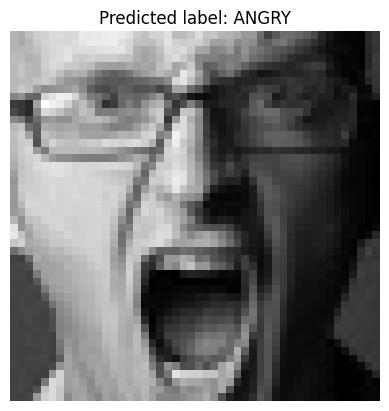

Enter the index of the image to predict (0 to 2143): 110
1/1 [==============================] - 0s 19ms/step


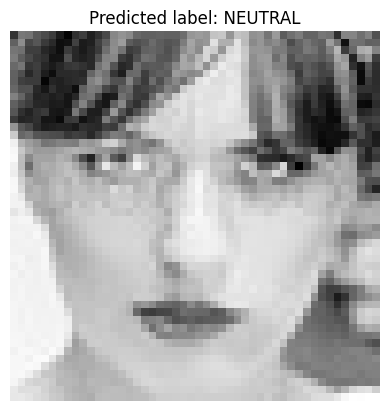

Enter the index of the image to predict (0 to 2143): 121
1/1 [==============================] - 0s 29ms/step


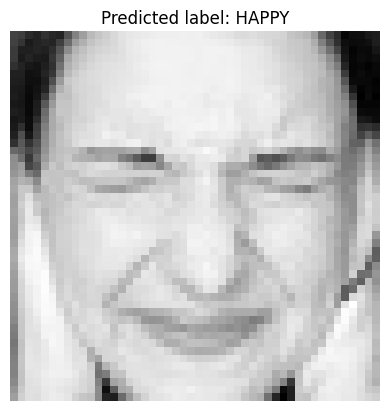

Enter the index of the image to predict (0 to 2143): 18
1/1 [==============================] - 0s 18ms/step


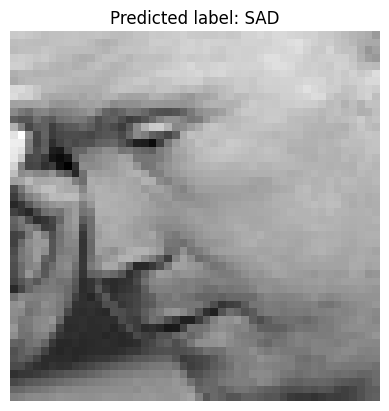

Enter the index of the image to predict (0 to 2143): 101
1/1 [==============================] - 0s 18ms/step


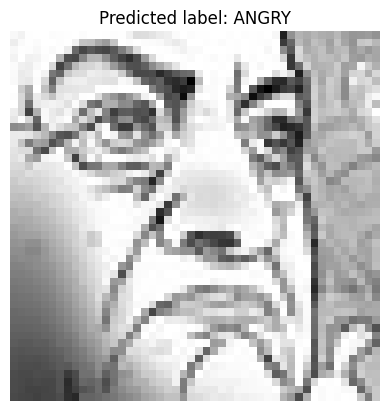

In [ ]:
def main():
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    emotion_classifier = load_model('detection_model.h5', compile=False)

    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_directory(
        val_dir,
        target_size=(48, 48),
        batch_size=32,
        color_mode='grayscale',
        class_mode='categorical',
        shuffle=False
    )

    X_test, y_test = next(test_generator)
    X_test = np.vstack([X_test for _ in range(test_generator.samples // test_generator.batch_size)])
    y_test = np.vstack([y_test for _ in range(test_generator.samples // test_generator.batch_size)])

    while True:
        choice = input("What mode of analysis do you prefer: Enter 1 for Camera, Enter 2 for Images: ")

        if choice == '1':
            analyze_camera(emotion_classifier, face_cascade)
            break
        elif choice == '2':
            while True:
                try:
                    index = int(input(f"Enter the index of the image to predict (0 to {len(X_test) - 1}): "))
                    if 0 <= index < len(X_test):
                        predict(index, X_test, emotion_classifier, emotion_labels)
                    else:
                        print(f"Invalid index. Please enter a number between 0 and {len(X_test) - 1}.")
                except ValueError:
                    print("Invalid input. Please enter a valid index number.")
            break
        else:
            print("Invalid choice. Please enter 1 or 2.")

if __name__ == "__main__":
    main()